In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt


In [2]:

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose

In [4]:
image_dataset_path = 'C:/Faiza Workfolder/Data science project/coding/PCB_dataset/images/'
csv_bounding_boxes = 'PCB_annotations_minimized_dataset.csv'
images = os.listdir(image_dataset_path)


In [5]:
bounding_boxes_data = pd.read_csv(csv_bounding_boxes, sep=";")

image_data = []
class_labels = []
mask_data= []

grouped_bbox = bounding_boxes_data.groupby('file')

In [6]:
for filename in images:
    image_path = os.path.join(image_dataset_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_array = np.asarray(gray_image) / 255.0 
    image_data.append(image_array)

    filename = os.path.splitext(filename)[0]
        
    mask = np.zeros((600, 600), dtype=np.uint8)

    if filename in grouped_bbox.groups:
        image_bbox_df = grouped_bbox.get_group(filename)

        for index, row in image_bbox_df.iterrows():
            class_label = row['class']
           
            xmin, ymin, xmax, ymax = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] 
            mask[ymin:ymax, xmin:xmax] = 255 
    
    mask = np.asarray(mask) / 255.0

    mask_array = np.asarray(mask)
            
    mask_data.append(mask_array)
    
    class_labels.append(class_label)

X_images = np.array(image_data)
y_bounding_boxes = np.array(mask_data)
y_class_labels = np.array(class_labels)

# class_label_mapping = {label: index for index, label in enumerate(np.unique(class_labels))}
# y_class_labels_numeric = np.array([class_label_mapping[label] for label in class_labels])

# num_classes = len(class_label_mapping)
# y_categorical = to_categorical(y_class_labels_numeric, num_classes=num_classes)

encoder = LabelEncoder()

y_class_labels_encoded = encoder.fit_transform(y_class_labels)
y_categorical = to_categorical(y_class_labels_encoded)


In [41]:
new_size = (100, 100)

cropped_images = []
cropped_masks = []
cropped_y_categorical = []
for image, mask, labels in zip(X_images, y_bounding_boxes, y_categorical):
  
    for y in range(0, 600, 100):
        for x in range(0, 600, 100):
            patch_image = image[y:y+100, x:x+100]
            patch_mask = mask[y:y+100, x:x+100]
            
            if np.any(patch_mask):
                cropped_images.append(patch_image)
                cropped_masks.append(patch_mask)
                cropped_y_categorical.append(labels)

cropped_images = np.array(cropped_images)
cropped_masks = np.array(cropped_masks)
cropped_y_categorical = np.array(cropped_y_categorical)

In [8]:
print(X_images.shape)
print(y_bounding_boxes.shape)
print(cropped_images.shape)
print(cropped_masks.shape)
print(cropped_y_categorical.shape)
print(len(X_images))
print(len(y_bounding_boxes))

(128, 600, 600)
(128, 600, 600)
(254, 100, 100)
(254, 100, 100)
(254, 3)
128
128


In [9]:
# Split data into train and validation sets
X_train, X_test, y_train_bbox, y_test_bbox, y_train_categorical, y_test_categorical= train_test_split(cropped_images, cropped_masks, cropped_y_categorical, 
                                                                                                      test_size=0.2, random_state=42)

In [10]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_bbox.shape)
print("y_train_categorical shape:", y_train_categorical.shape)
print("X_test shape:", X_test.shape)
print("y_test_bbox shape:", y_test_bbox.shape)
print("y_test_categorical shape:", y_test_categorical.shape)

X_train shape: (203, 100, 100)
y_train_bbox shape: (203, 100, 100)
y_train_categorical shape: (203, 3)
X_test shape: (51, 100, 100)
y_test_bbox shape: (51, 100, 100)
y_test_categorical shape: (51, 3)


In [12]:
# Data Augmentation:
# rotation ,width_shift, height_shift, shear, zoom, horizontal_flip

def augment_data(images, masks, labels):
    augmented_images = []
    augmented_masks = []
    augmented_labels = []

    for image, mask, labels in zip(images, masks, labels):
        augmented_images.append(image)
        augmented_masks.append(mask)
        augmented_labels.append(labels)

        shear_image, shear_mask = shear(image, mask)
        augmented_images.append(shear_image)
        augmented_masks.append(shear_mask)
        augmented_labels.append(labels)
        # print("Shear:", shear_image.shape, shear_mask.shape)

        flip_image, flip_mask = flip(image, mask)
        augmented_images.append(flip_image)
        augmented_masks.append(flip_mask)
        augmented_labels.append(labels)
        # print("Flip:", flip_image.shape, flip_mask.shape)

        zoom_image, zoom_mask = zoom(image, mask)
        augmented_images.append(zoom_image)
        augmented_masks.append(zoom_mask)
        augmented_labels.append(labels)
        # print("Zoom:", zoom_image.shape, zoom_mask.shape)

        width_shift_image, width_shift_mask = width_shift(image, mask)
        augmented_images.append(width_shift_image)
        augmented_masks.append(width_shift_mask)
        augmented_labels.append(labels)
        # print("Width Shift:", width_shift_image.shape, width_shift_mask.shape)

        height_shift_image, height_shift_mask = height_shift(image, mask)
        augmented_images.append(height_shift_image)
        augmented_masks.append(height_shift_mask)
        augmented_labels.append(labels)
        # print("Height Shift:", height_shift_image.shape, height_shift_mask.shape)

        rotate_image, rotate_mask = rotate(image, mask)
        augmented_images.append(rotate_image)
        augmented_masks.append(rotate_mask)
        augmented_labels.append(labels)
        # print("Rotation:", rotate_image.shape, rotate_mask.shape)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_masks, augmented_labels

def shear(image, mask):
    shear_factor = np.random.uniform(-0.2, 0.2)
    rows, cols = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    shear_image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    shear_mask = cv2.warpAffine(mask, shear_matrix, (cols, rows))

    padded_image = np.zeros((100, 100), dtype=np.uint8)
    padded_mask = np.zeros((100, 100), dtype=np.uint8)
    padded_image[:rows, :cols] = shear_image
    padded_mask[:rows, :cols] = mask

    return shear_image, shear_mask

def flip(image, mask):
    flip_image = cv2.flip(image, 1)
    flip_mask = cv2.flip(mask, 1)
    return flip_image, flip_mask

def zoom(image, mask):
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    zoomed_mask = cv2.resize(mask, None, fx=zoom_factor, fy=zoom_factor)

    rows, cols = zoomed_image.shape[:2]
    if rows < 100 or cols < 100:
        pad_rows = max(0, (100 - rows) // 2)
        pad_cols = max(0, (100 - cols) // 2)
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_rows, 100 - rows - pad_rows, pad_cols, 100 - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
        zoomed_mask = cv2.copyMakeBorder(zoomed_mask, pad_rows, 100 - rows - pad_rows, pad_cols, 100 - cols - pad_cols, cv2.BORDER_CONSTANT, value=0)
    elif rows > 100 or cols > 100:
        zoomed_image = zoomed_image[:100, :100]
        zoomed_mask = zoomed_mask[:100, :100]

    return zoomed_image, zoomed_mask

def width_shift(image, mask):
    shift_x = np.random.uniform(-0.2, 0.2) * image.shape[1]
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, 0]])
    width_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    width_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if width_shift_image.shape[1] > 100:
        width_shift_image = width_shift_image[:, :100]
        width_shift_mask = width_shift_mask[:, :100]
    elif width_shift_image.shape[1] < 100:
        pad_width = 100 - width_shift_image.shape[1]
        width_shift_image = np.pad(width_shift_image, ((0, 0), (0, pad_width), (0, 0)), mode='constant')
        width_shift_mask = np.pad(width_shift_mask, ((0, 0), (0, pad_width), (0, 0)), mode='constant')

    return width_shift_image, width_shift_mask

def height_shift(image, mask):
    shift_y = np.random.uniform(-0.2, 0.2) * image.shape[0]
    translation_matrix = np.float32([[1, 0, 0], [0, 1, shift_y]])
    height_shift_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    height_shift_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))

    if height_shift_image.shape[0] > 100:
        height_shift_image = height_shift_image[:100, :]
        height_shift_mask = height_shift_mask[:100, :]
    elif height_shift_image.shape[0] < 100:
        pad_height = 100 - height_shift_image.shape[0]
        height_shift_image = np.pad(height_shift_image, ((0, pad_height), (0, 0), (0, 0)), mode='constant')
        height_shift_mask = np.pad(height_shift_mask, ((0, pad_height), (0, 0), (0, 0)), mode='constant')

    return height_shift_image, height_shift_mask

def rotate(image, mask):
    angle = np.random.uniform(-20, 20)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotate_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    rotate_mask = cv2.warpAffine(mask, rotation_matrix, (cols, rows))

    if rotate_image.shape[0] > 100 or rotate_image.shape[1] > 100:
        rotate_image = cv2.resize(rotate_image, (100, 100))
        rotate_mask = cv2.resize(rotate_mask, (100, 100))
    elif rotate_image.shape[0] < 100 or rotate_image.shape[1] < 100:
        pad_height = max(0, 100 - rotate_image.shape[0])
        pad_width = max(0, 100 - rotate_image.shape[1])
        rotate_image = np.pad(rotate_image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        rotate_mask = np.pad(rotate_mask, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    return rotate_image, rotate_mask


In [13]:
X_train_augmented, y_train_augmented, y_train_categorical_augmented = augment_data(X_train, y_train_bbox, y_train_categorical)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train_bbox shape:", y_train_bbox.shape)
print("y_train_categorical shape:", y_train_categorical.shape)

print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("y_train_categorical_augmented shape:", y_train_categorical_augmented.shape)

X_train shape: (203, 100, 100)
y_train_bbox shape: (203, 100, 100)
y_train_categorical shape: (203, 3)
X_train_augmented shape: (1421, 100, 100)
y_train_augmented shape: (1421, 100, 100)
y_train_categorical_augmented shape: (1421, 3)


In [15]:
# Combining images and masks into tuples
combined_data = list(zip(X_train_augmented, y_train_augmented, y_train_categorical_augmented))

# Shuffle the dataset
np.random.shuffle(combined_data)


Batch of images shape: (1421, 100, 100)
Batch of labels shape: (1421, 100, 100)
Batch of labels shape: (1421, 3)
Labels: [1. 0. 0.]
Integer label: missing_hole


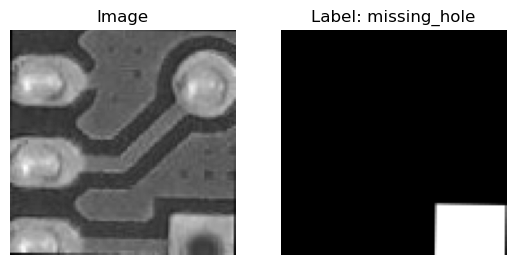

In [18]:
# plt.imshow(train_dataset)
# i=92

class_labels = {
    (1, 0, 0): 'missing_hole',
    (0, 1, 0): 'mouse_bite',
    (0, 0, 1): 'open_circuit'
}

def label_to_int(label):
    return class_labels[tuple(label)]

np.random.shuffle(combined_data)

for images, masks, labels in combined_data:
    print("Batch of images shape:", X_train_augmented.shape)
    print("Batch of labels shape:", y_train_augmented.shape)
    print("Batch of labels shape:", y_train_categorical_augmented.shape)
    print("Labels:", labels)

    plt.subplot(1, 2, 1)
    plt.imshow(images.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks.squeeze(), cmap='gray')

    conv_label = label_to_int(labels)
    print("Integer label:", conv_label)
    plt.title(f'Label: {conv_label}') 

    plt.axis('off')
    plt.show()

    break 

In [19]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [49]:
early_stopping = EarlyStopping(
                                patience=5, 
                                min_delta = 0.01, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=5, 
                                    episilon= 0.01,
                                    factor=0.1,  
                                    cooldown = 4, 
                                    verbose=1)

time_callback = TimingCallback()


In [42]:
def enhanced_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up1 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up1)

    up2 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(up2)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [43]:
# Instantiate the model
model = enhanced_unet(input_shape=(100, 100, 1))

In [44]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy', 'mae'])  

In [45]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 100,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 25, 25,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 50, 50,    │     32,832 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 50, 50,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 50, 50,    │     73,792 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 100, 100,  │      8,224 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 100, 100,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 100, 100,  │     18,464 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 100, 100,  │         33 │ conv2d_10[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,017 (882.88 KB)

 Trainable params: 226,017 (882.88 KB)

 Non-trainable params: 0 (0.00 B)

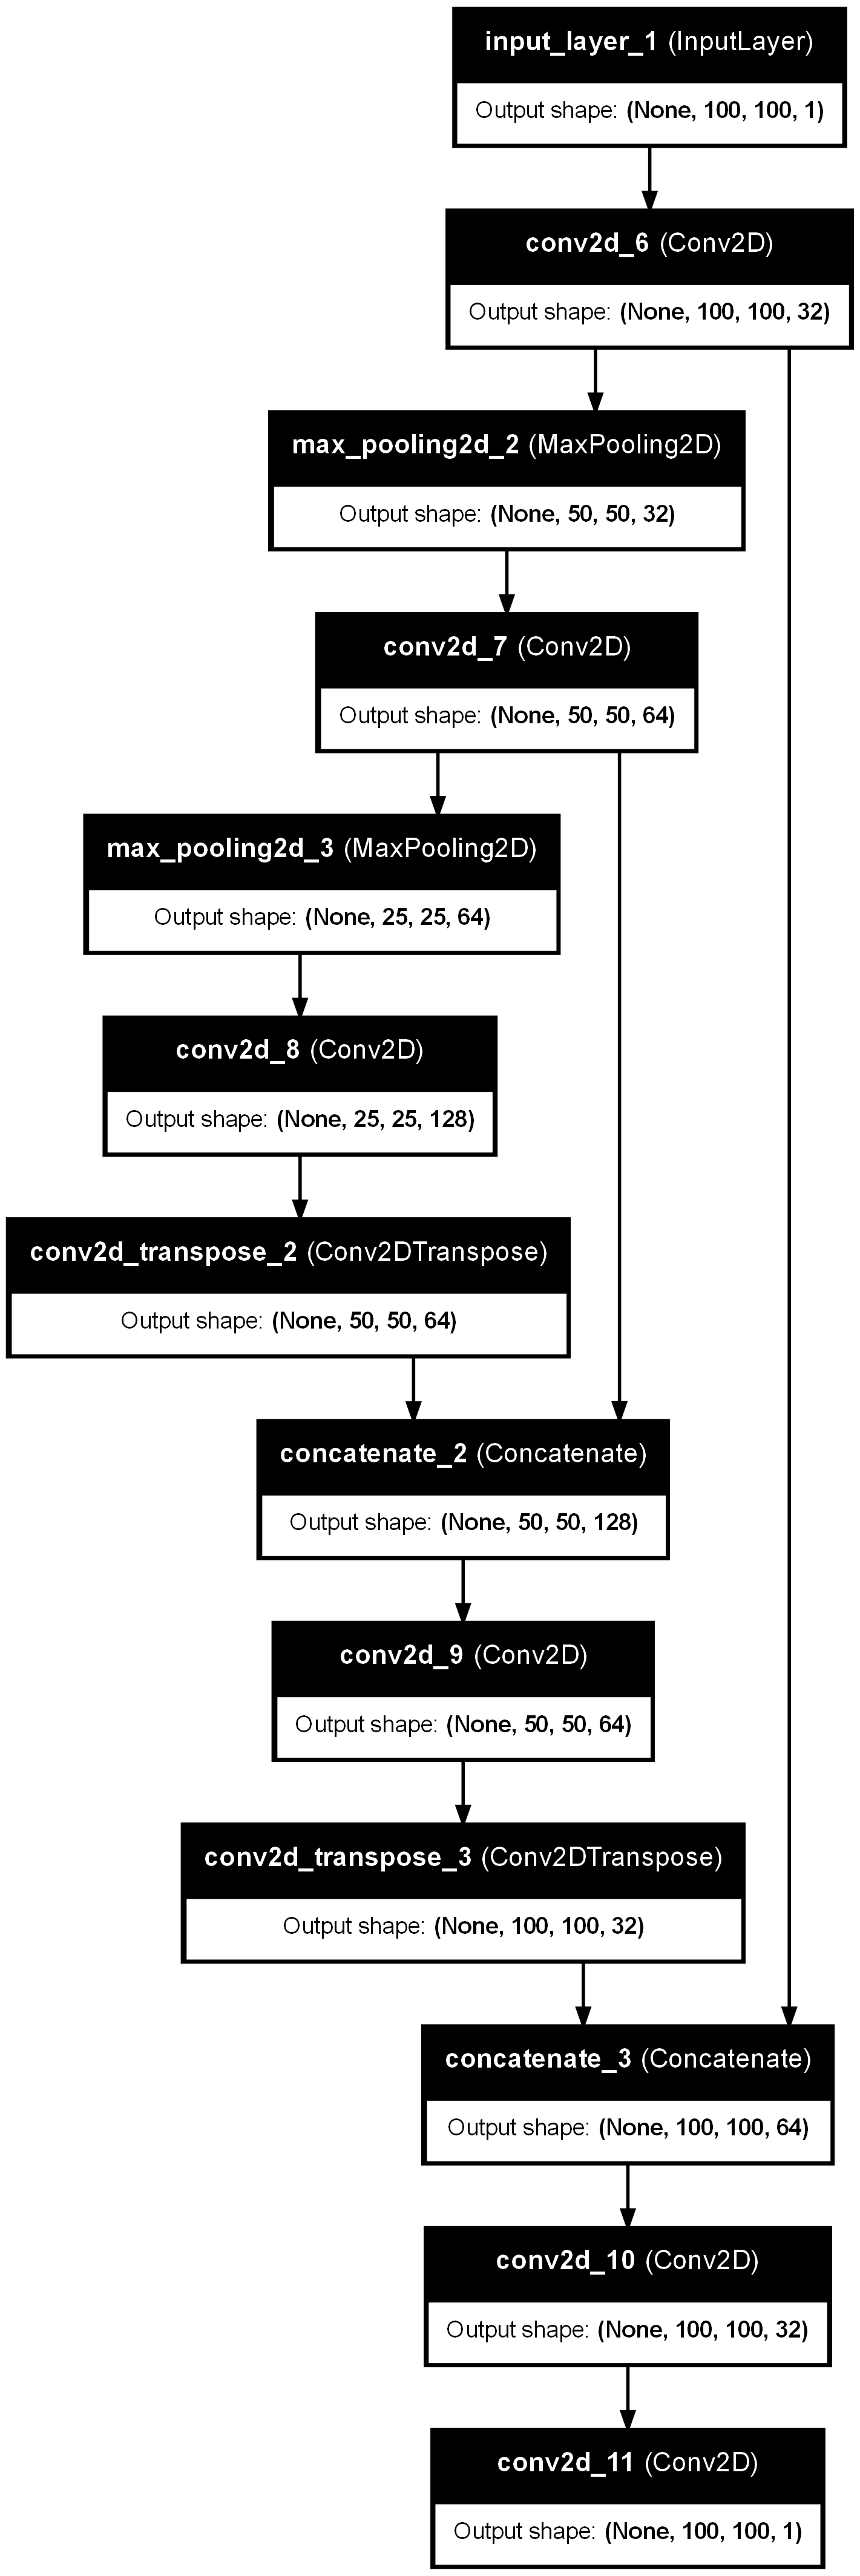

In [46]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [47]:
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("y_train_categorical_augmented shape:", y_train_categorical_augmented.shape)
print("Expected input shape for the model:", model.input_shape)

print("Model output shape:", model.output_shape)

print("Data type of y_train_augmented:", y_train_augmented.dtype)

X_train_augmented shape: (1421, 100, 100)
y_train_augmented shape: (1421, 100, 100)
y_train_categorical_augmented shape: (1421, 3)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: (None, 100, 100, 1)
Data type of y_train_augmented: float64


In [56]:
# Train the model
history = model.fit(x=X_train_augmented, 
                    y=y_train_augmented,
                    epochs=16,
                    batch_size=32,
                    validation_data=(X_test, y_test_bbox),
                    # callbacks=[reduce_learning_rate, early_stopping, time_callback],
                    verbose=True)

Epoch 1/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9461 - loss: 0.2037 - mae: 0.0987 - val_accuracy: 0.9534 - val_loss: 0.1847 - val_mae: 0.0839
Epoch 2/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9444 - loss: 0.2056 - mae: 0.0991 - val_accuracy: 0.9534 - val_loss: 0.1808 - val_mae: 0.0928
Epoch 3/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9436 - loss: 0.1999 - mae: 0.1011 - val_accuracy: 0.9534 - val_loss: 0.1706 - val_mae: 0.0797
Epoch 4/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9473 - loss: 0.1742 - mae: 0.0897 - val_accuracy: 0.9534 - val_loss: 0.1752 - val_mae: 0.0790
Epoch 5/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9453 - loss: 0.1718 - mae: 0.0919 - val_accuracy: 0.9534 - val_loss: 0.1538 - val_mae: 0.0917
Epoch 6/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9453 - loss: 0.1580 - mae: 0.0880 - val_accuracy: 0.9569 - val_loss: 0.1416 - val_mae: 0.0716
Epoch 7/16
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - 

In [57]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]


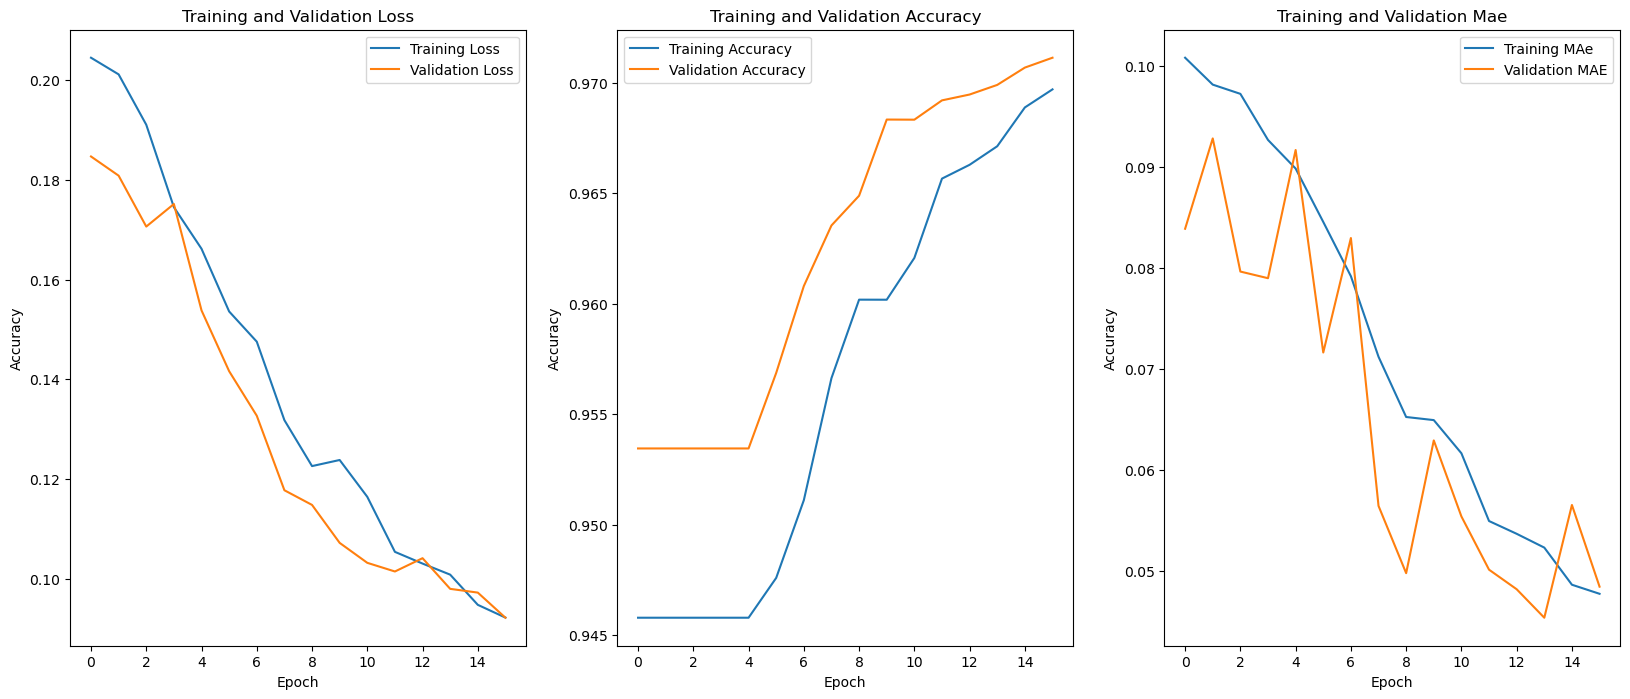

In [58]:

plt.figure(figsize = (20, 8))

plt.subplot(131)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(132)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(133)
plt.plot(train_mae, label="Training MAe")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Mae")
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


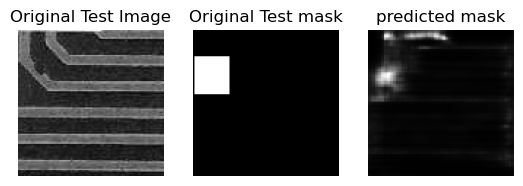

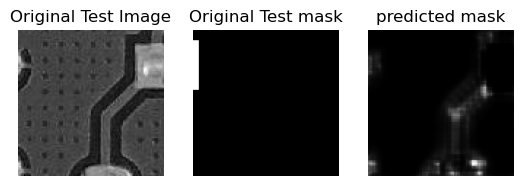

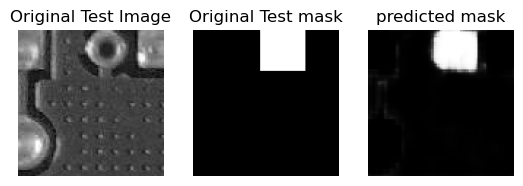

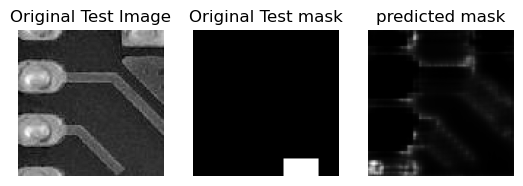

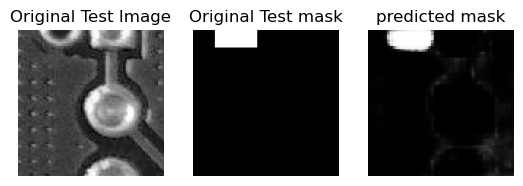

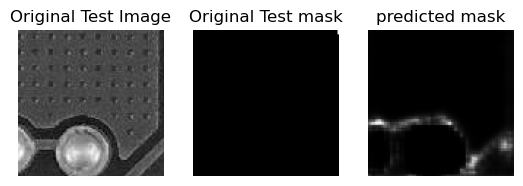

In [59]:
y_val_pred = model.predict(X_test)

for i in range(6):

    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_bbox[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask')
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_val_pred[i].squeeze(), cmap='gray')  
    plt.title('predicted mask')
    plt.axis('off')

    plt.show()
    

In [60]:
image_test = cv2.imread('C:/Faiza Workfolder/Data science project/coding/PCB_dataset/images/l_light_01_missing_hole_01_2_600.jpg')

image_test = cv2.resize(image_test, (600, 600))  # Resize
gray_image = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
image_array_test = np.asarray(gray_image) / 255.0 #normalize

In [61]:
image_array_test = np.expand_dims(image_array_test, axis=0)  # Add batch dimension
y_pred = model.predict(image_array_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


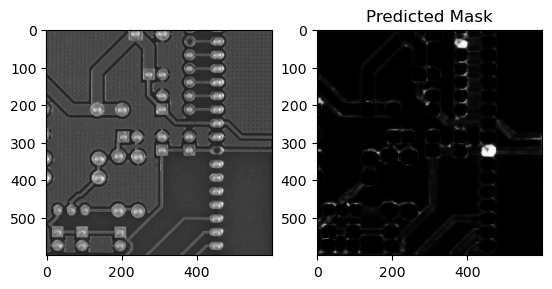

In [62]:

plt.subplot(121) 
plt.imshow(gray_image.squeeze(), cmap='gray')

plt.subplot(122) 
plt.imshow(y_pred.squeeze(), cmap='gray')
plt.title('Predicted Mask')
plt.show()